In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gtsam

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object

In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.0333333,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.4,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

<Axes: xlabel='x', ylabel='y'>

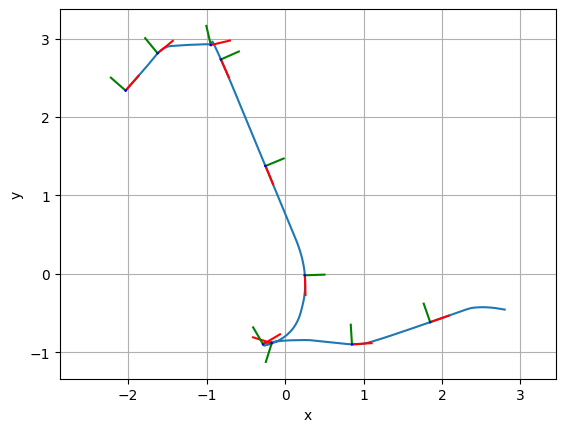

In [3]:
t0 = 104
tf = 120
pose_data.plot2d(t0=100, tf=120, pose=False, dt=.1)
pose_data.plot2d(t0=100, tf=120, trajectory=False, pose=True, dt=2., axis_len=.25)
# pose_data.plot2d(t0=t0, tf=tf, trajectory=True, pose=True, dt=2., axis_len=.25)

<Axes: xlabel='x', ylabel='y'>

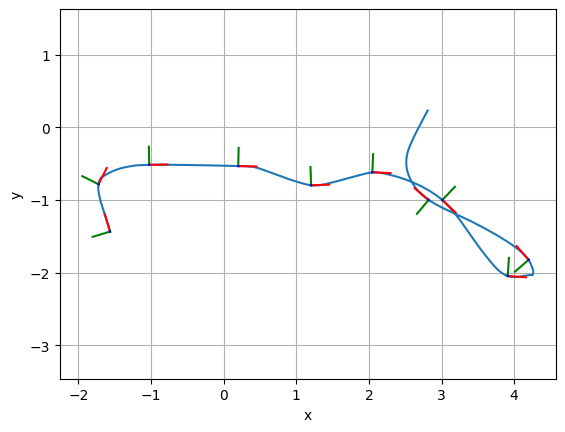

In [4]:
pose_data.plot2d(t0=200, tf=220, pose=False, dt=.1)
pose_data.plot2d(t0=200, tf=220, trajectory=False, pose=True, dt=2., axis_len=.25)

In [5]:
# T_BC = np.array([
#     - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
#     -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
# ]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cpu'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)


Fusing layers... 


In [6]:
all_observations = []
for t in np.arange(t0, tf, .05):
    try:
        img = img_data.img(t)
        pose = pose_data.T_WB(t)
    except:
        continue
    observations = fastsam.run(t, pose, img)
    all_observations.append(observations)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 160x256 7 objects, 110.1ms
Speed: 1.7ms preprocess, 110.1ms inference, 14.4ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 77.0ms
Speed: 0.3ms preprocess, 77.0ms inference, 11.8ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 78.4ms
Speed: 0.6ms preprocess, 78.4ms inference, 16.4ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 74.4ms
Speed: 0.3ms preprocess, 74.4ms inference, 13.5ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objects, 73.9ms
Speed: 4.3ms preprocess, 73.9ms inference, 19.8ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objects, 74

In [7]:
tracker = Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25
)

for observations in all_observations:
    if len(observations) > 0:
        tracker.update(observations[0].time, observations)


In [8]:
print(len(tracker.segments))
print(len(tracker.segment_nursery))
print(len(tracker.segment_graveyard))

5
7
62


[    0.33952    -0.94322     0.28824]
[    0.84951     0.64293     0.30163]


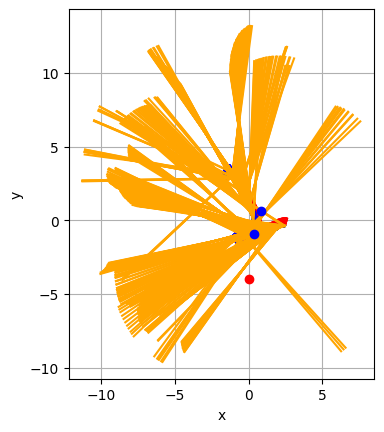

In [9]:
obs_lists = [seg.observations for seg in tracker.segments + tracker.segment_graveyard]
all_obs = [obs for obs_list in obs_lists for obs in obs_list]

plt.plot(0, -4, 'ro')
for obs in all_obs:
    pose_data.plot2d(t=obs.time, pose=True, axis_len=.5)
    
for obs in all_obs[:]:
    det_vec_c = np.linalg.inv(cam_params.K) @ np.array([obs.pixel[0], obs.pixel[1], 1]).reshape((3,1))
    det_vec = obs.pose[:3,:3] @ det_vec_c
    det_vec = det_vec[:2] / np.linalg.norm(det_vec[:2])
    det_vec *= 10
    plt.plot([obs.pose[0,3], obs.pose[0,3] + det_vec.item(0)], [obs.pose[1,3], obs.pose[1,3] + det_vec.item(1)], 'orange')

plt.gca().set_aspect('equal', adjustable='box')

for segment in tracker.segments:
    try:
        position = segment.reconstruction3D()
        print(position)
        plt.plot(position[0], position[1], 'bo')
    except:
        pass

In [10]:
boxes = np.array([
    [2.33, -2.03],
    [2.16, -1.65],
    [4.2, 0.5],
    [4.48, 1.73],
    [5.05, 3.24],
    [5.42, 3.43],
    [2.28, 1.94],
    [1.98, 2.19],
    [0.41, 2.39],
    [0.07, 2.64],
    [1.03, .48],
    [-1., 1.63],
    [-.86, -1.42],
    [-.33, -1.83],
    [-.73, -1.97],
    [-0.3, -3.46],
    [-1.79, 0.5],
    [-1.89, 1.13],
    [-2.86, 2.74],
    [-2.61, 2.78],
    [-3.37, 0.67],
    [-3.03, 0.19],
    [-2.36, -1.52],
])

In [44]:
def reconstruction3D(segment, width_height=False):
    camera_poses = []
    for obs in segment.observations:
        camera_poses.append(gtsam.PinholeCameraCal3DS2(gtsam.Pose3(obs.pose), segment.cal3ds2))
    camera_set = gtsam.gtsam.CameraSetCal3DS2(camera_poses)
    pixels_point_vec = gtsam.Point2Vector([gtsam.Point2(obs.pixel) for obs in segment.observations])
    measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, segment.pixel_std_dev)
    reconstruction = gtsam.triangulatePoint3(camera_set, pixels_point_vec, rank_tol=1e-9, optimize=True, model=measurement_noise)

    if width_height:
        ws, hs = [], []
        for obs in segment.observations:
            p_c = transform(np.linalg.inv(obs.pose), reconstruction)
            ws.append(obs.width * np.abs(p_c[0]) / np.abs(obs.pixel[0] - segment.camera_params.K[0,2]))
            hs.append(obs.height * np.abs(p_c[1]) / np.abs(obs.pixel[1] - segment.camera_params.K[1,2]))
        # print(ws)
        return np.concatenate((reconstruction, [np.mean(ws)], [np.mean(hs)]))
            
    return reconstruction

0.19564137004560275
missed this one
missed this one
0.24324946901099959
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
missed this one
0.8007434760817921
missed this one
0.35341137036177117
0.9801569950985494
0.23366832499023882
0.21543446357469498
0.28620002221969165
0.9321316573511309
0.2125791057029713
0.16980945562244515
0.3244985104016514
0.4546696325980606
0.312990498638217
1.5401065074274203
0.944934278105839
missed this one
0.2934361631277422
0.4288580696468579
missed this one
missed this one
1.2469528090068858
0.042473015083653934
0.04902722828879615
0.11578742901081497
0.2027288439165
0.6495274236209267
0.24129494774217783
0.1441460847930518
0.7764618185861099
0.21413730239603826
0.2431867732669997
0.21286955705722294
missed this one
0.7205530189840011
0.15559049372254705
1.9043857987436004
missed this one
0.11705872576515472
0.23121471340642688
0.34056851213264955
0.5646353285544906
0.2924633121100036
0.2533774215850401
1.2160

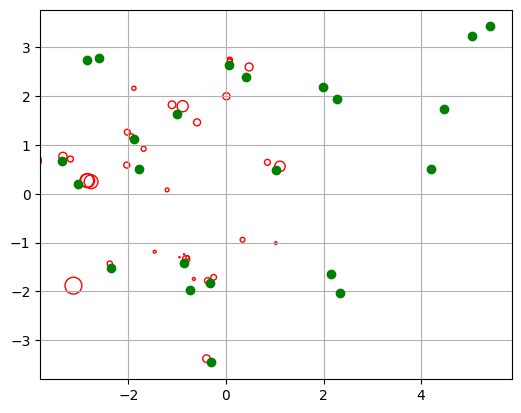

In [55]:
fig, ax = plt.subplots()
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
for segment in tracker.segments + tracker.segment_graveyard:
    segment.camera_params = cam_params
    try:
        # reconstruction = segment.reconstruction3D(width_height=True)
        reconstruction = reconstruction3D(segment, width_height=True)
        print(reconstruction[3])
        ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([reconstruction[3]/2, reconstruction[3]/2]), rot_mat=np.eye(2))

        ellipsoid.plot2d(ax, edgecolor='r')
        # ax.plot(position[0], position[1], 'bx')
    except:
        print("missed this one")
# seg = tracker.segment_graveyard[10]
# reconstruction = reconstruction3D(seg, width_height=True)
# object = Object(reconstruction[:2])
# object.plot2d(ax)